In [ ]:
# %matplotlib notebook
import numpy as np
from scipy.optimize import least_squares, differential_evolution
from matplotlib import pyplot as plt,cm
import plotly.express as px
from pandas import DataFrame
import pandas as pd
import os
import datetime as dt
from scipy.stats import norm
from scipy import signal
from tqdm.notebook import tqdm,trange
!pip install py_vollib
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility as impl
import warnings
from IPython.display import display, Math, Latex

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Input, ELU, add
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback, TensorBoard
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.initializers import VarianceScaling, RandomUniform
from tensorflow.keras.utils import plot_model

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%tensorflow_version 2.2.0
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [3]:
data_dir = '/content/drive/My Drive/rough_heston_calib/'
moneyness = [.8, .85, .9, .95, .975, .99, 1.0, 1.01, 1.025, 1.05, 1.1, 1.15, 1.2] # S_0/K 
ytms = [0.5,0.6,0.75,1.,1.25,1.5,1.75,2.]
# ytms = [0.5,0.6,0.75,1.,1.25,1.5,1.75,2.,2.5,3.,3.5,4.,4.5,5.]
# ytms = [0.25,0.30,0.35,.4,.5,.6,.7,.85,1.,1.25,1.5]
# ytms = np.array([15,30,45, 60, 90, 120, 180, 240, 300, 360, 420])/365
X,Y=np.meshgrid( moneyness, ytms )
df = DataFrame(np.concatenate((Y.reshape(-1,1),X.reshape(-1,1)),axis=1),columns=['ytms','moneyness'])

In [4]:
def plt_surf(Z,W=None, z_label='ivs', main_title='rHeston Imp Vola Surface',subtitle='', string1='', string2='',save=False):
    
    X, Y = np.meshgrid( moneyness, ytms )
    Z = Z.reshape(len(X),len(X[0]))
    fig = plt.figure()
    if W is None:
        ax = fig.add_subplot(1, 1, 1, projection='3d', xlabel='time to maturity in years', ylabel='moneyness', zlabel=z_label)
        ax.text2D(0.06, 0.98, string1, transform=ax.transAxes)
        surf=ax.plot_surface(Y, X, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.set_figheight(8); fig.set_figwidth(8)
        fig.colorbar(surf, shrink=0.6, aspect=20,ax=ax)
    else:
        fig.set_figheight(8); fig.set_figwidth(16)
        ax1 = fig.add_subplot(1, 2, 1, projection='3d', xlabel='time to maturity in years', ylabel='moneyness', zlabel=z_label)
        ax1.zaxis.labelpad=15
        ax1.text2D(0.2, 0.98, string1, transform=ax1.transAxes)
        surf1=ax1.plot_surface(Y, X, Z, cmap=cm.Blues, linewidth=0, antialiased=True)
        fig.colorbar(surf1, shrink=0.6, aspect=20)
        
        W = W.reshape(len(X),len(X[0]))
        ax2 = fig.add_subplot(1, 2, 2, projection='3d', xlabel='time to maturity in years', ylabel='moneyness', zlabel=z_label)
        ax2.zaxis.labelpad=15
        ax2.text2D(0.2, 0.98, string2, transform=ax2.transAxes)
        surf2=ax2.plot_surface(Y, X, W, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf2, shrink=0.6, aspect=20)
                       
    fig.suptitle(main_title+'\n'+subtitle)
    if save:
        output_dir = '/Users/egeyilmaz/Desktop/ivs/'+str(today)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        file_id = str(len([iq for iq in os.scandir(output_dir)]))
        plt.savefig(output_dir +'/'+file_id+'.jpg',dpi=600)
    plt.subplots_adjust(top=0.8)
    plt.show()

In [5]:
"""
d X_t =(r - V_t / 2) * dt + sqrt(V_t) * d W_t
V_t = Phi(G^alpha Y)_t = V_0 + (G^alpha Y)_t
d Y_t = (theta - kappa * Y_t) * dt + sigma * sqrt(Y_t) * d B_t
d[W_t, B_t] = rho * dt
"""
class rHeston:
    def __init__(self,create_new=True, spot=50., risk_free_rate=0.01,dividend_rate=0.01, inst_vola=0.1, inst_vola_of_vola=0.1,
                        mean_rev_speed=1, eq_var=0.1, vola_of_vola=0.1, correlation=0.1, alpha=-0.25,verbose=True):
        if create_new==True:
            self.create_model(verbose=verbose)
        else:
            self.spot=spot; self.X_0 = np.log(spot); self.V_0 = inst_vola; self.Y_0 = inst_vola_of_vola
            self.kappa = mean_rev_speed; self.theta = eq_var; self.sigma = vola_of_vola; self.rho = correlation
            self.alpha = alpha 
            self.ir = risk_free_rate; self.dr = dividend_rate
            
            obs_str = ['S_{0} =', 'ir =', 'dr =', 'v_{0} =','y_{0} =']
            self.obs = [self.spot, self.ir, self.dr, self.V_0, self.Y_0]
            self.obs_str = ["${}{:.6}$".format(o, str(v)) for o,v in zip(obs_str, self.obs)]
            params_str = [r'\kappa = ', r'\theta = ', r'\sigma = ', r'\rho = ']
            self.params = [self.kappa, self.theta, self.sigma, self.rho]
            self.params_str = ["${}{:.5}$".format(o, str(v)) for o,v in zip(params_str, self.params)]
            self.latex=Latex('$' + ',\hspace{1mm}'.join(i[1:-1] for i in [*self.obs_str,*self.params_str]) + '$')
            if verbose:
                print('New model initialized with:')
                display(self.latex)
                # print(self.obs_str,self.params_str)
        
            self.df = df; self.df['strikes'] = self.spot/self.df['moneyness'] 
            self.ivs=None

    def __generate_ir(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.08)
    def __generate_dr(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.03)
    def __generate_sp(self):
        return 100*(np.random.beta(a=8, b=8) + 1.0E-2)
    def __generate_theta(self):
        return np.random.uniform(low=0.05, high=0.8)
    def __generate_v0(self):
        return np.random.uniform(low=0.01, high=0.5)**2
    def __generate_y0(self):
        return np.random.uniform(low=0.01, high=0.5)**2
    def __generate_rho(self):
        return np.random.uniform(low= -0.99, high= 0.99)
    def __generate_kappa(self):
        return np.random.uniform(low=0.5, high=10.)
    def __generate_sigma(self):
        return np.random.uniform(low=0.05, high=0.8)
#     def __generate_alpha(self):
#         return alpha
    
    def create_model(self,create_new=False, **kwargs):
        ir = kwargs.get('ir', self.__generate_ir())
        dr = kwargs.get('dr', self.__generate_dr())
        sp = kwargs.get('sp', self.__generate_sp())
        v0 = kwargs.get('v0', self.__generate_v0())
        y0 = kwargs.get('y0', self.__generate_y0())
        rho = kwargs.get('rho', self.__generate_rho())
        sigma = kwargs.get('sigma', self.__generate_sigma())
        # Loop until the Feller condition is satisfied
        theta = kwargs.get('theta', self.__generate_theta())
        kappa = kwargs.get('kappa', self.__generate_kappa())
        while 2*kappa*theta <= sigma**2:
            theta = self.__generate_theta()
            kappa = self.__generate_kappa()

        self.__init__(create_new=create_new, spot=sp, risk_free_rate=ir,
                            dividend_rate=dr, inst_vola=v0,inst_vola_of_vola=y0,
                            mean_rev_speed=kappa, eq_var=theta, vola_of_vola=sigma, 
                            correlation=rho,verbose=kwargs.get('verbose',1))
        
    def create_training_data(self, save=True, **kwargs):
        custom = kwargs.get('custom',False)
        if custom:
            nb_samples = int(input("No of samples:")); n = int(input("n:")); m = int(input("m:"))
        else:
            nb_samples = 20000; n = 40; m = 100000
        pbar = tqdm(total = nb_samples)
        input_name='heston_train_inputNN_drive'; output_name='heston_train_outputNN_drive'
        print('NN-training data are produced')
        if os.path.isfile(data_dir+'/'+input_name+'.npy') and os.path.isfile(data_dir+'/'+output_name+'.npy'):
            x = np.load(data_dir+'/'+input_name+'.npy'); y = np.load(data_dir+'/'+output_name+'.npy')
            assert(x.shape[0]==y.shape[0]),'Existing data shapes do not match!'
            assert(x.shape[1]==9),'X data shape {} do not match no of parameters!'.format(x.shape)
            i=x.shape[0]
            print('%s samples already exist.Continuing...'%(i))
            pbar.update(i)
            x=list(x);y=list(y)
        else:
            print('No samples found. Fresh start.')
            x = []; y = []; i = 0
        err_no=0
        while i<nb_samples:
            try:
                self.simulate(n,m,called_by_function=True)
            except Exception as e:
                err_no+=1
                print(e,'Problem occured @sample %s' %(i+1))
                print('Tot. no. of Errors: %s' %err_no)
            except KeyboardInterrupt:
                print('Training data generation has been interrupted.')
                if  save == True:
                    print('Saving progress...')
                    np.save(data_dir+'/'+input_name, x)
                    np.save(data_dir+'/'+output_name, y)
                    print('Done.')
                    return
                else:
                    return
            else:
                x.append([*self.obs,*self.params])
                y.append(self.ivs)
                i += 1
                pbar.update(1)
                if not i%100:
                    print('Creating checkpoint...')
                    np.save(data_dir+'/'+input_name, x)
                    np.save(data_dir+'/'+output_name, y)
                    print('Checkpoint at sample %s created. Continuing...'%i)
        pbar.close()
        if  save == True:
            print('Saving data for training of NN as heston_train_inputNN and heston_train_outputNN')
            np.save(data_dir+'/'+input_name, x)
            np.save(data_dir+'/'+output_name, y)
            print('Done!')
    
    def simulate(self,n,m,called_by_function=False):
        self.n=n ; self.m=m
        try:
            #print('Creating new model...')
            self.create_model()
            self.get_ivs()
        except Exception as err:
            if called_by_function:
                raise err; return
            else:
                return self.simulate(n,m)
    
    def get_ivs(self,**kwargs):
        self.ivs= kwargs.get('ivs',self.ivs)
        if self.ivs==None:
            self.n=kwargs.get('n',40); self.m=kwargs.get('m',100000)
            self.df['prices'] = self.get_prices(n=self.n,m=self.m)
            self.ivs = np.array([impl(self.df['prices'][i], self.spot, self.df['strikes'][i],
                              self.df['ytms'][i], self.ir,self.dr, 'c') for i in range(len(self.df['prices']))])
        save=kwargs.get('save',False)
        if kwargs.get('show',0):
            subtitle= kwargs.get('subtitle','')
            plt_surf( Z=np.array(self.ivs), z_label='ivs', 
                     main_title='rHeston Imp Vola Surface n= %s,m=$10^{%1s}$'%(self.n,int(np.log10(self.m))),
                     subtitle=subtitle,
                     string1=', '.join(o for o in self.obs_str)+ '\n' + ', '.join(p for p in self.params_str),save=save)
    
    def get_prices(self,n,m,save=False):
        self.T = self.df['ytms'].max(); prices=[]; self.q=self.ir-self.dr
        self.S = self.rough_heston_underlying(n,m,self.T).transpose(1,0); self.V = self.V.transpose(1,0)
        
        t=list(map(int, [0,*(self.df['ytms'].unique()*n/self.T-1)]))
        S=np.empty((m,0)); V=np.empty((m,0)); delta_S=np.empty((m,0))
        
        for i,ytm in tqdm(enumerate(self.df['ytms'].unique()), total=len(self.df['ytms'].unique())):
            S=np.concatenate((S,self.S[:,t[i]:t[i+1]+1]),axis=1)
            delta_S=np.diff(S,axis=1);S=S[:,:-1]
            V=np.concatenate((V,self.V[:,t[i]:t[i+1]]),axis=1)
            times = np.linspace(0,ytm,t[i+1]+1)
            delta_temp=np.log(S)+(ytm-times[:-1])*(self.q+0.5*V**2)/(0.00001+np.sqrt(ytm-times[:-1])*np.sqrt(V))
            delta_hedge_temp0 = np.exp(self.q*(ytm-times[1:]))* delta_S
            delta_hedge_temp1 = S*( np.exp(self.q*np.diff(times)) - 1)
            for k in self.df['strikes'].unique():
                delta = norm.cdf( (delta_temp-np.log(k)))
                delta_hedge = np.sum( delta_hedge_temp0* delta  - delta_hedge_temp1, axis=1)
                prices.append((np.maximum(self.S[:,t[i+1]]- k, 0) - delta_hedge).mean())
        if save==True:
            np.save('prices',prices)
        return np.exp((-1)*self.q*self.df['ytms'])*prices
    
    
    def rough_heston_underlying(self,n,m,T):  
        self.V, self.B = self.rough_vola(n,m, T, self.Y_0, self.V_0, self.kappa, 
                                                    self.theta, self.sigma, self.alpha)
        X = self.__get_heston_log_price(n,m, T, self.X_0,self.ir,self.dr, self.V, 
                                                         self.__get_correlated_bm(self.rho, self.B))
        return np.exp(X)

    def rough_vola(self,n,m, T, Y_0, V_0, kappa, theta, sigma, alpha):
        sqrtn = np.sqrt(n); Y = np.zeros((n,m));Y[0]=Y_0; B = np.random.normal(0.0, 1.0, size=(n,m))
        g_vector=np.zeros((n,)); g_vector[1:] = np.array([np.power(T * i / n, alpha) for i in range(1, n)])
        for i in range(1, n):
            Y[i] = Y[i-1] + (T/n)*kappa *(theta - np.maximum(0, Y[i - 1])) + (T/sqrtn)*sigma * np.sqrt(np.maximum(0, Y[i - 1]))*B[i]
            if Y[i].any()<-.5:
                raise Exception('Volatility %s below threshold at iter %s' %(Y[i],i))
        Y=np.maximum(Y, 0)
        dY = Y[1:] - Y[:-1]
        V = np.zeros((n,m)); V[0]=V_0
        for i in range(m):
            V[1:,i] = V_0 + np.sqrt((T/n))*signal.convolve(dY[:,i] , g_vector[1:])[:n-1]
        if V.min()<-1.:
            raise Exception('Rough Volatility %s below threshold at iter %s' %(V[i],i))
        V=np.maximum(V, 0)
        return V, B

    def __get_heston_log_price(self,n,m, T, X_0,r,q, V, W):
        X = np.zeros((n,m))
        X[0]=X_0
        for i in range(1, n):
            X[i] = X[i-1] + ((r-q) - 0.5* V[i-1])*(T/n) + np.sqrt((T/n) * V[i-1]) * W[i]
        return X
    
    def __get_correlated_bm(self,rho, B):
        W = rho * B + np.sqrt(1 - np.power(rho, 2)) * np.random.normal(0.0, 1.0, size=B.shape)
        return W
h=rHeston()

New model initialized with:


<IPython.core.display.Latex object>

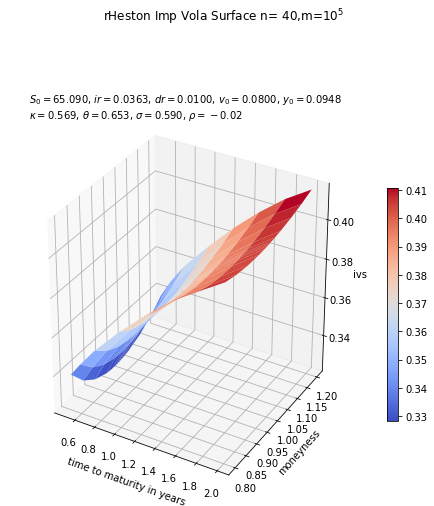

In [6]:
h.get_ivs(show=1)

In [7]:
import sklearn as sk
from sklearn.model_selection import train_test_split

params=np.load('/content/drive/My Drive/rough_heston_calib/heston_train_inputNN.npy')
iv=np.load('/content/drive/My Drive/rough_heston_calib/heston_train_outputNN.npy')

params_train, params_valid, iv_train, iv_valid=sk.model_selection.train_test_split(params,iv, train_size=0.8, random_state=1)
print('training data size: ',params_train.shape[0],'; validation data size: ',params_valid.shape[0],'; total: ',params.shape[0])

training data size:  33156 ; validation data size:  8289 ; total:  41445


In [8]:
def generate_nn(nb_unit=int(2**9), layers=10, activation=tf.nn.relu, optimizer=Adam(learning_rate=0.001)):
    init= tf.keras.initializers.GlorotUniform(seed=1)
    ## Input of model
    input = Input(shape=(9,))
    # First layer
    x = Dense(nb_unit, kernel_initializer=init,kernel_constraint=MaxNorm(5, axis=0))(input)
    # x = BatchNormalization()(x)
    x = activation(x)
    x = Dropout(0)(x)

    # Middle layers
    for i in range(layers-1):
        x = Dense(nb_unit, kernel_initializer=init, kernel_constraint=MaxNorm(5, axis=0))(x)
        # x = BatchNormalization()(x)
        x = activation(x)
        x = Dropout(0)(x)
        # x = activation(x)

    # Last layer
    x = Dense(104, kernel_initializer=init, kernel_constraint=MaxNorm(5, axis=0))(x)
    # x = BatchNormalization()(x)
    x = Activation('linear')(x)
    x = Dropout(0)(x)

    ## Put together input and output
    nn = Model(inputs=input, outputs=x)

    # Compile
    nn.compile(optimizer, loss='mse',metrics=['accuracy'])
    
    return nn

In [9]:
class decay_lr(Callback):
    def __init__(self, n_epoch, decay_rate):
        super().__init__()
        self.n_epoch=n_epoch; self.decay_rate=decay_rate
    def on_epoch_begin(self, epoch,logs=None):
        config=self.model.optimizer.get_config()
        if epoch > 1 and epoch%self.n_epoch == 0 :
            config['learning_rate']*=self.decay_rate
            self.model.optimizer=self.model.optimizer.from_config(config)

In [10]:
# %%time
# reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1000, min_lr=9e-10, verbose=1)
# earlyStopping = EarlyStopping(monitor='val_loss', patience=1000)
# LRScheduler = decay_lr(500,0.5)
# nn=generate_nn(layers=4)
# history = nn.fit( params_train, iv_train, batch_size=1024, epochs=8000, verbose=2, callbacks=[reduceLR,LRScheduler,earlyStopping],
#                           validation_data=(params_valid, iv_valid) )

In [11]:
# tf.keras.models.save_model(nn, data_dir+'/model')

In [12]:
nn = tf.keras.models.load_model(data_dir+'/model')

In [13]:
# def create_test_data(test_count):
#   heston=rHeston(verbose=0);test_in=[];test_out=[]
#   np.random.seed(0)
#   for i in trange(test_count):
#     heston.simulate(40,100000)
#     test_in.append([*heston.obs,*heston.params])
#     test_out.append(heston.ivs)
#   return test_in,test_out
# test_in,test_out=create_test_data(10)
# np.save(data_dir+'test_in',test_in);np.save(data_dir+'test_out',test_out)
# print('Test data saved.')

In [14]:
def f_cal(neural_map,x,y, l2=False):
    def cost_function(params):
        params = params.flatten().tolist()
        input_params = [*x]
        input_params.extend(params)
        prediction = neural_map.predict( np.array( [input_params] ) )
        diff = prediction - y #absolute error
        if l2:
            return np.sum(diff**2)
        else:
            return np.sum(np.abs(diff))
    return cost_function

In [15]:
def illustration_plot(neuralnet):
    try:
        test_in=np.load(data_dir+'test_in.npy');test_out=np.load(data_dir+'test_out.npy')
    except Exception as e:
        print(e,'\nPlease run “create_test_data“ function to get test data!')
    obs_str = ['$S_{0} =$', 'ir =', 'dr =', '$v_{0} =$','$y_{0} =$']
    params_str = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $']
    for x,y in zip(test_in,test_out):
        Z_test=neuralnet.predict(np.array([x])).ravel()
        string=', '.join(s for s in [o +'%.5s'%v for o,v in zip(obs_str,x[:5])])+ '\n' + ', '.join(s for s in [o +'%.5s'%v for o,v in zip(params_str,x[5:])])
        str1 = 'Neural Network' 
        str2='Ground Truth'
        subtitle=('Illustration Plot\n'+string)
        assert(Z_test.shape==y.shape),'Prediction data shape {} do not match ground truth data shape {}!'.format(Z_test.shape,y)
        plt_surf(Z=Z_test,W=y,subtitle=subtitle,string1=str1,string2=str2)

In [16]:
he_calibration_bounds = [(0.5,10.), (0.05,0.8), (0.05,0.8), (-0.99,0.99)]
def calibration_plot(neuralnet):
    solutions=pd.DataFrame(columns=['$\kappa$', '$\theta$', '$\sigma$', '$\rho$'])
    try:
        test_in=np.load(data_dir+'test_in.npy');test_out=np.load(data_dir+'test_out.npy')
    except Exception as e:
        print(e,'\nPlease run “create_test_data“ function to get test data!')
    obs_str = ['$S_{0} =$', 'ir =', 'dr =', '$v_{0} =$','$y_{0} =$']
    params_str = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $'] 
    tqdm.write('Calibration with DE has started...', end='\n', nolock=False)
    for i,(x,y) in tqdm(enumerate(zip(test_in,test_out)),total=len(test_in)):
        tqdm.write('Inverting the price map for sample %s'%(i+1), end='\n', nolock=False)
        pbar = tqdm(total = 150)
        def diff_evo_callback(xk,convergence):
            pbar.update(1)
            diff = np.sum((x[5:]-xk)**2)
            # print(convergence,diff)
            if diff < 0.005:
                return True
            else:
                return False
        sol = differential_evolution(f_cal(neuralnet,x[:5],y,True), maxiter=150,bounds=he_calibration_bounds,tol=0.0001,seed=1,callback=diff_evo_callback)
        tqdm.write('Done!', end='\n', nolock=False)
        pbar.close()
        solutions.loc[i]=[*sol.x]
        test=[*x[:5], *sol.x ]; test=np.array([test])
        Z_test=neuralnet.predict(test).ravel() 
        str1 = 'Neural Network\n' + ', '.join(s for s in [o +'%.5s'%v for o,v in zip(params_str,sol.x)])
        str2='Ground Truth\n' + ', '.join(s for s in [o +'%.5s'%v for o,v in zip(params_str,x[5:])])
        subtitle=('Calibration Plot (DE)\n' + ', '.join(s for s in [o +'%.5s'%v for o,v in zip(obs_str,x[:5])]))
        plt_surf(Z=Z_test,W=y,subtitle=subtitle,string1=str1,string2=str2)

    solutions.to_pickle(data_dir+'DE_solutions.pkl')
    tqdm.write('Calibration with DE has been completed.', end='\n', nolock=False)
    tqdm.write('Solutions have been saved to '+data_dir+'DE_solutions.pkl', nolock=False)

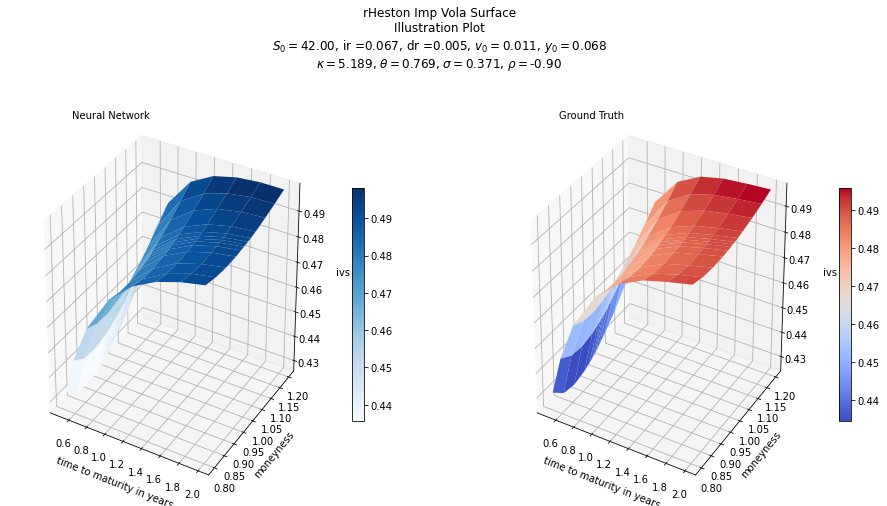

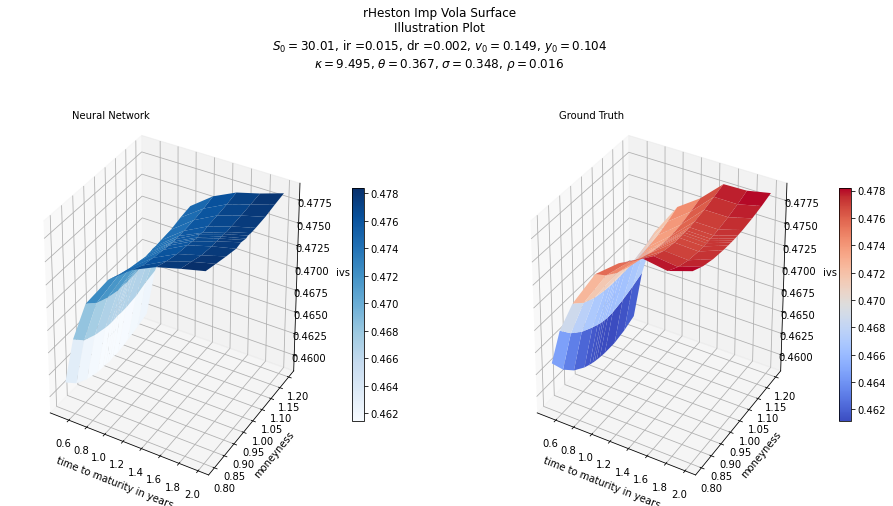

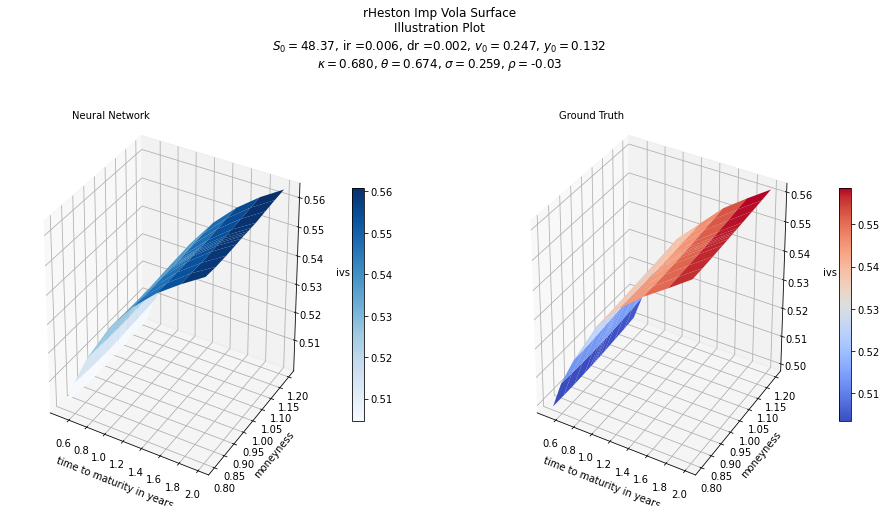

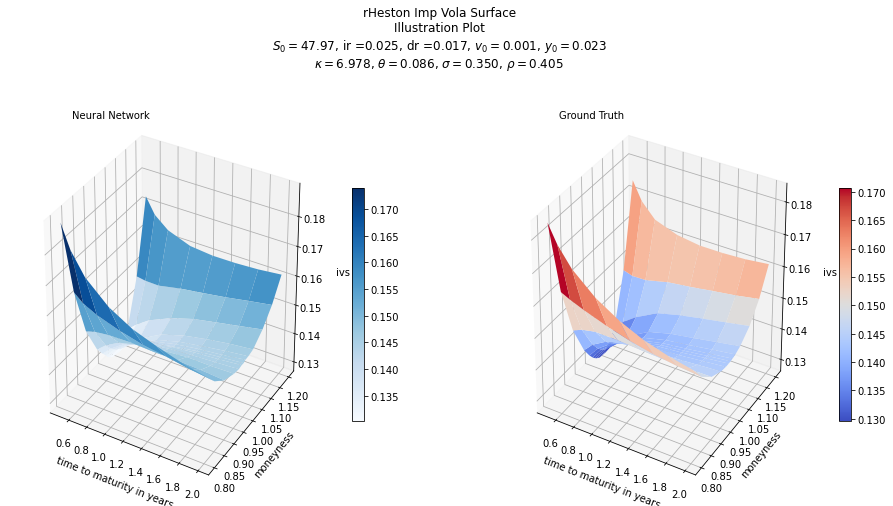

In [17]:
illustration_plot(nn)

Calibration with DE has started...


Inverting the price map for sample 1


Done!



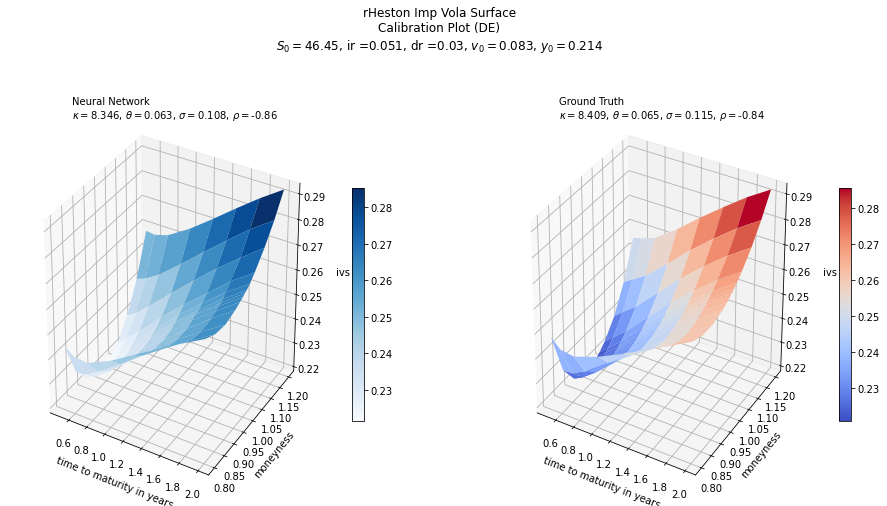

Inverting the price map for sample 2


Done!



Inverting the price map for sample 3


Done!



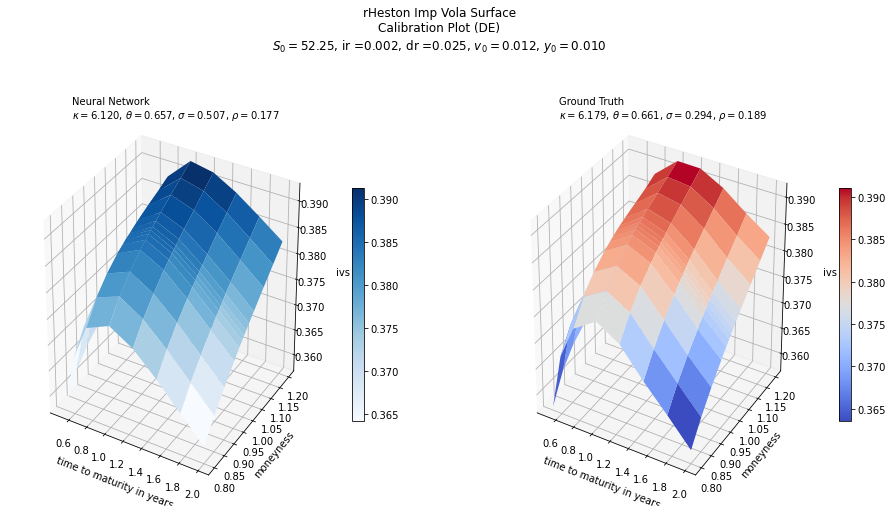

Inverting the price map for sample 4


Done!



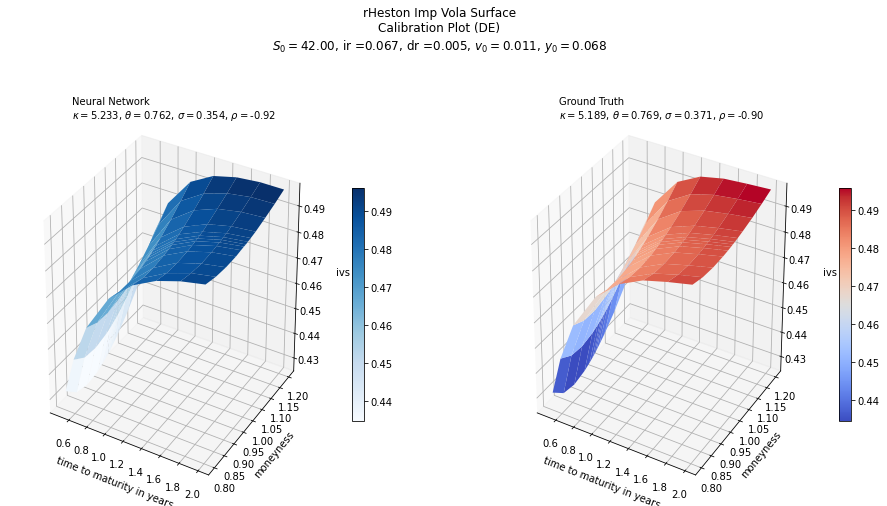

Inverting the price map for sample 5


Done!



Inverting the price map for sample 6


Done!



Inverting the price map for sample 7


Done!



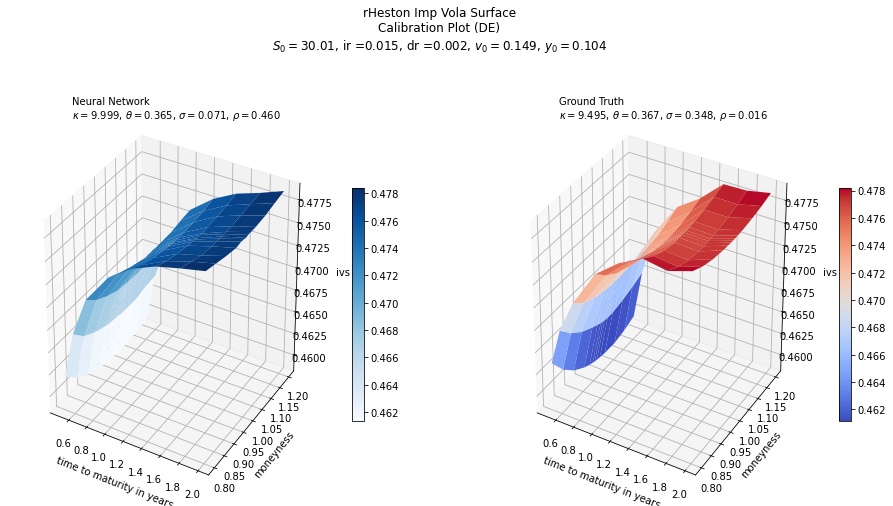

Inverting the price map for sample 8


Done!



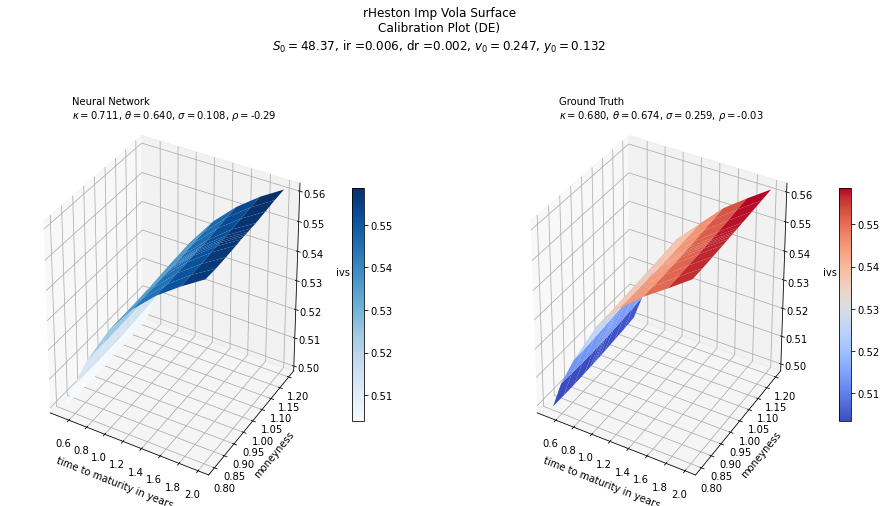

Inverting the price map for sample 9


Done!



Inverting the price map for sample 10


Done!




Calibration with DE has been completed.
Solutions have been saved to /content/drive/My Drive/rough_heston_calib/DE_solutions.pkl


In [18]:
calibration_plot(nn)

Calibration with SGD has started...


Inverting the price map for sample 1


Inverting the price map for sample 2


Inverting the price map for sample 3


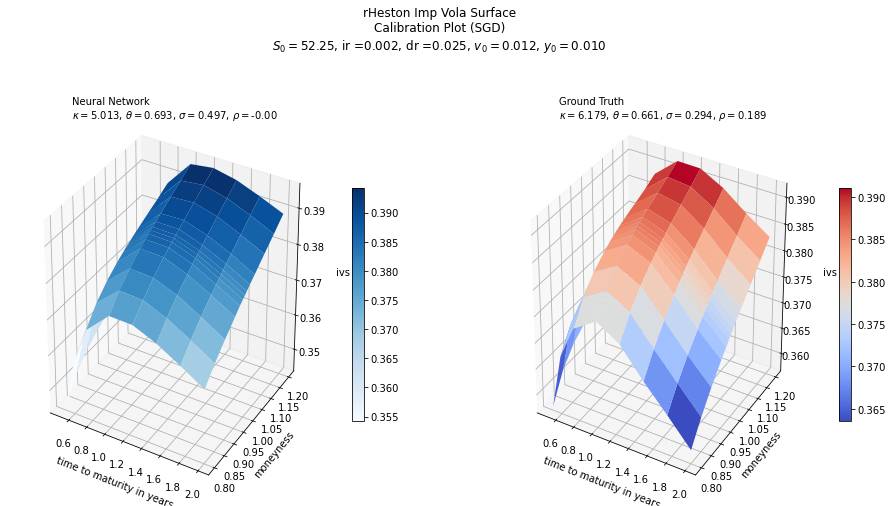

Inverting the price map for sample 4


Inverting the price map for sample 5


Inverting the price map for sample 6


Inverting the price map for sample 7


Inverting the price map for sample 8


Inverting the price map for sample 9


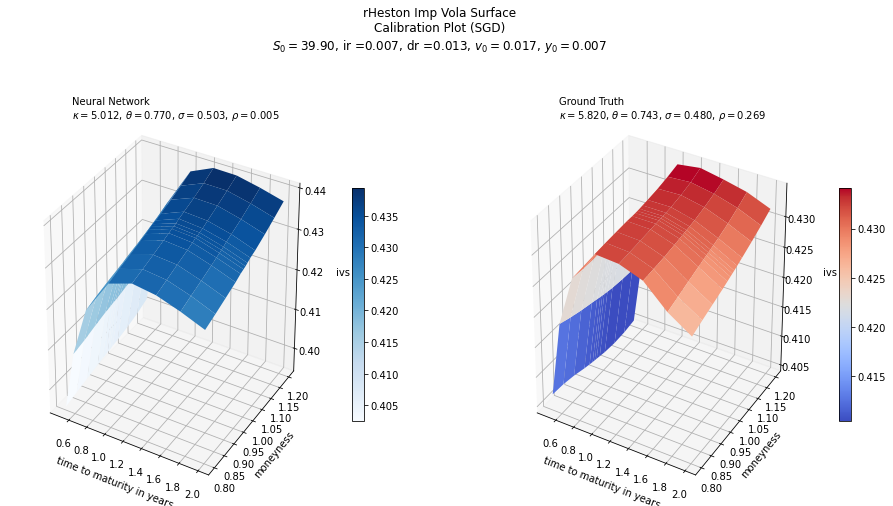

Inverting the price map for sample 10


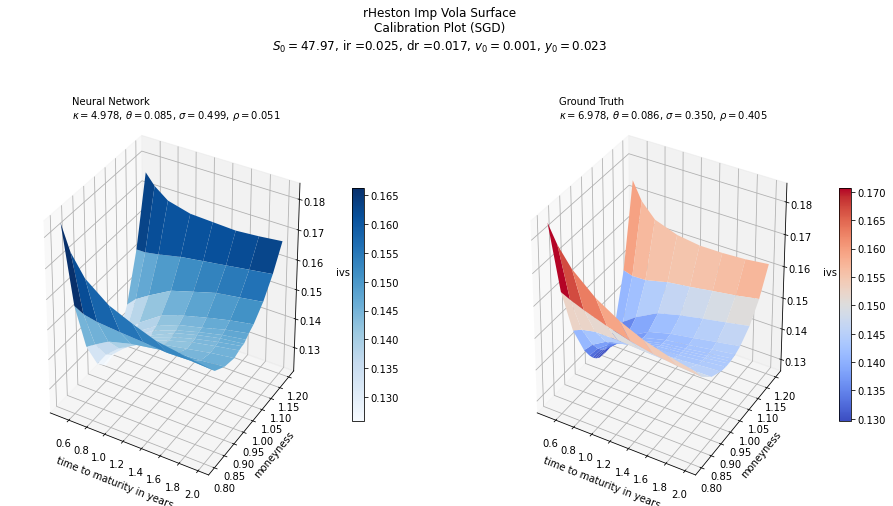


Calibration with SGD has been completed.
Solutions have been saved to /content/drive/My Drive/rough_heston_calib/SGD_solutions.pkl


In [19]:
class BackPropagator:
    def __init__(self, **kwargs):
        assert(os.path.exists(data_dir+'/model')),'No saved model found.'
        self.nn_inv=tf.keras.models.load_model(data_dir+'/model')
        for layer in self.nn_inv.layers:
            layer.trainable=False
        self.nn_inv.layers[0].trainable=True
        self.init_vals=kwargs.get('initial_values',[5.,1.,.5,0.])

        assert(os.path.exists(data_dir+'test_in.npy')) and os.path.exists(data_dir+'test_out.npy'),'No test data found.'
        self.test_in=np.load(data_dir+'test_in.npy');self.test_out=np.load(data_dir+'test_out.npy')

        self.opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    def loss(self,y,kappa, theta, sigma, rho):
        params=tf.stack([[self.s0,self.ir,self.dr,self.v0,self.y0,kappa,theta,sigma,rho]])
        return tf.reduce_sum((self.nn_inv.call(params) - y)**2)

    def reset(self,**kwargs):
        random=kwargs.get('random',0)
        seed=kwargs.get('seed',None)
        if seed is not None:
            np.random.seed(seed)	
        kappa = tf.Variable(np.random.uniform(0.001,10.),dtype='float32') if random else tf.Variable(self.init_vals[0],dtype='float32')
        theta = tf.Variable(np.random.uniform(0.001,0.8),dtype='float32') if random else tf.Variable(self.init_vals[1],dtype='float32')
        sigma = tf.Variable(np.random.uniform(0.05,0.8),dtype='float32') if random else tf.Variable(self.init_vals[2],dtype='float32')
        rho = tf.Variable(np.random.uniform(-0.99,0.99),dtype='float32') if random else tf.Variable(self.init_vals[3],dtype='float32')
        return kappa,theta,sigma,rho

    def backprop(self,**kwargs):
        solutions=pd.DataFrame(columns=['$\kappa$', '$\theta$', '$\sigma$', '$\rho$'])
        tqdm.write('Calibration with SGD has started...', end='\n', nolock=False)
        for k,(x,y) in tqdm(enumerate(zip(self.test_in,self.test_out)),total=len(self.test_in)):
            tqdm.write('Inverting the price map for sample %s'%(k+1), end='\n', nolock=False)
            self.s0,self.ir,self.dr,self.v0,self.y0=[tf.constant(i,dtype='float32') for i in x[:5]]
            kappa,theta,sigma,rho= self.reset()
            for i in trange(5000):
                with tf.GradientTape() as tape:
                    tape.watch([kappa, theta, sigma, rho])
                    loss = self.loss(y,kappa, theta, sigma, rho)
                if loss< 0.001:
                    print('Loss: %.7s is below given threshold.'%loss.numpy(),'Skipping to next calibration...')
                    break
                grads = tape.gradient(loss, [kappa, theta, sigma, rho])
                processed_grads = [g for g in grads]
                grads_and_vars = zip(processed_grads, [kappa, theta, sigma, rho])
                if kwargs.get('verbose',0):
                    print ('y = {:.3f},kappa = {:.3f}, theta = {:.3f},sigma = {:.3f}, \
                              rho = {:.3f}, grads0 = {:.1f}, grads1 = {:.1f},grads2 = {:.1f}, grads3 = {:.1f}'.format
                                (y.numpy(), kappa.numpy(), theta.numpy(),sigma.numpy(),rho.numpy(),grads[0].numpy(), 
                                       grads[1].numpy(),grads[2].numpy(), grads[3].numpy()))
                self.opt.apply_gradients(grads_and_vars)
            solutions.loc[k]=[kappa.numpy(), theta.numpy(), sigma.numpy(), rho.numpy()]
            if kwargs.get('plot',0):
                obs_str = ['$S_{0} =$', 'ir =', 'dr =', '$v_{0} =$','$y_{0} =$']
                params_str = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $'] 
                params=tf.stack([[self.s0,self.ir,self.dr,self.v0,self.y0,kappa,theta,sigma,rho]])
                output=self.nn_inv.call(params)
                str1 = 'Neural Network\n' + ', '.join(s for s in [o +'%.5s'%v for o,v in zip(params_str,solutions.loc[k])])
                str2='Ground Truth\n' + ', '.join(s for s in [o +'%.5s'%v for o,v in zip(params_str,x[5:])])
                subtitle=('Calibration Plot (SGD)\n' + ', '.join(s for s in [o +'%.5s'%v for o,v in zip(obs_str,x[:5])]))
                plt_surf(Z=output.numpy(),W=y,subtitle=subtitle,string1=str1,string2=str2)
        solutions.to_pickle(data_dir+'SGD_solutions.pkl')
        tqdm.write('Calibration with SGD has been completed.', end='\n', nolock=False)
        tqdm.write('Solutions have been saved to '+data_dir+'SGD_solutions.pkl', nolock=False)

# BackPropagator(initial_values=[6.5,0.6,0.3,0.1]).backprop(plot=1)
BackPropagator().backprop(plot=1)

In [20]:
class Results:
    def __init__(self):
        assert(os.path.isfile(data_dir+'test_in.npy') and os.path.isfile(data_dir+'test_in.npy')),'No test data found.'
        assert(os.path.isfile(data_dir+'DE_solutions.pkl')),'No calibration with differential evolution has been performed yet.'
        assert(os.path.isfile(data_dir+'SGD_solutions.pkl')),'No calibration with stochastic gradient descent has been performed yet.'
        self.test_in=np.load(data_dir+'test_in.npy'); self.test_out=np.load(data_dir+'test_out.npy')
        self.n=len(self.test_in)
        self.df_params=pd.DataFrame(columns=['kappa', 'theta', 'sigma', 'rho'])
        self.df_obs=pd.DataFrame(columns=['S0', 'ir', 'dr', 'v0','y0'])
        for i,x in enumerate(self.test_in):
            self.df_obs.loc[i]=x[:5]; self.df_params.loc[i]=x[5:]
        self.df_test=pd.concat([self.df_obs,self.df_params],axis=1)
        self.df_DE=pd.DataFrame(pd.read_pickle(data_dir+'DE_solutions.pkl').to_numpy(),columns=['kappa', 'theta', 'sigma', 'rho'])
        self.df_SGD=pd.DataFrame(pd.read_pickle(data_dir+'SGD_solutions.pkl').to_numpy(),columns=['kappa', 'theta', 'sigma', 'rho'])
    
    def Errors(self,**kwargs):
        return_list=[]
        if kwargs.get('normalize',0):
            self.df_params=self.df_params.apply(lambda x: x/np.sqrt((x**2).sum()),axis=1)
            self.df_DE = self.df_DE.apply(lambda x: x/np.sqrt((x**2).sum()),axis=1)
            self.df_SGD = self.df_SGD.apply(lambda x: x/np.sqrt((x**2).sum()),axis=1)
            print('Data points have been normalized.')

        self.df_abs_DE=pd.DataFrame(np.array(abs(self.df_params - self.df_DE)),columns=pd.MultiIndex.from_tuples([('Abs Error (DE)',i) for i in self.df_params.columns])).round(4)
        self.df_abs_SGD = pd.DataFrame(np.array(abs(self.df_params - self.df_SGD)),columns=pd.MultiIndex.from_tuples([('Abs Error (SGD)',i) for i in self.df_params.columns])).round(4)
        self.df_rel_DE=pd.DataFrame((self.df_abs_DE.to_numpy()/ abs(self.df_params).to_numpy())*100,columns=pd.MultiIndex.from_tuples([('Rel Error (DE)',i) for i in self.df_params.columns])).round(2)
        self.df_rel_SGD=pd.DataFrame((self.df_abs_SGD.to_numpy()/ abs(self.df_params).to_numpy())*100,columns=pd.MultiIndex.from_tuples([('Rel Error (SGD)',i) for i in self.df_params.columns])).round(2)
        
        self.df_avg_rel_DE = pd.DataFrame(np.array([self.df_rel_DE.sum()/self.n]), index=['Avg Rel Error (DE)'], columns=self.df_params.columns).round(2)
        self.df_avg_rel_SGD = pd.DataFrame(np.array([self.df_rel_SGD.sum()/self.n]), index=['Avg Rel Error (SGD)'], columns=self.df_params.columns).round(2)
        
        self.df_rel_DE,self.df_rel_SGD, self.df_avg_rel_DE,self.df_avg_rel_SGD=[i.applymap(lambda x: str(x)+'%') for i in [self.df_rel_DE,self.df_rel_SGD, self.df_avg_rel_DE,self.df_avg_rel_SGD] ]

        self.df_avg_abs_DE = pd.DataFrame(np.array([self.df_abs_DE.sum()/self.n]), index=['Avg Abs Error (DE)'], columns= self.df_params.columns)
        self.df_avg_abs_SGD = pd.DataFrame(np.array([self.df_abs_SGD.sum()/self.n]),index=['Avg Abs Error (SGD)'], columns=self.df_params.columns)
        
        self.df_DE_L1 = pd.DataFrame(self.df_avg_abs_DE.to_numpy().sum(axis=1), index=['Avg L1 Dist (DE)'])
        self.df_SGD_L1 = pd.DataFrame(self.df_avg_abs_SGD.to_numpy().sum(axis=1), index=['Avg L1 Dist (SGD)'])
        
        self.df_DE_L2= pd.DataFrame([(np.sqrt((self.df_abs_DE.to_numpy()**2).sum(axis=1))).sum(axis=0)/self.n], index=['Avg L2 Dist (DE)'])
        self.df_SGD_L2= pd.DataFrame([(np.sqrt((self.df_abs_SGD.to_numpy()**2).sum(axis=1))).sum(axis=0)/self.n], index=['Avg L2 Dist (SGD)'])
        return_list.append(pd.concat([self.df_abs_DE,self.df_abs_SGD,self.df_rel_DE,self.df_rel_SGD],axis=1))
        return_list.append(pd.concat([self.df_avg_rel_DE,self.df_avg_rel_SGD,self.df_avg_abs_DE,self.df_avg_abs_SGD],axis=0))
        return_list.append(pd.concat([self.df_DE_L1,self.df_SGD_L1,self.df_DE_L2,self.df_SGD_L2],axis=0))

        self.__init__()

        if kwargs.get('verbose',0):
            print('Errors calculated over %s tests.' %self.n)
            print('@index 0: Abs and Rel Errors, @index 1: Avg Abs and Avg Rel Errors, @index 2: L1 and L2 distances of calibration points to ground truth')
        return return_list
        
    def DE_vs_SGD(self):
        self.Errors()
        mask=(pd.DataFrame((self.df_abs_DE.to_numpy() - self.df_abs_SGD.to_numpy()))>0).applymap(func= lambda x:'SGD' if x else 'DE')
        return pd.DataFrame(mask.to_numpy(), columns=pd.MultiIndex.from_tuples([('DE vs SGD (Better performing method is indicated)',i) for i in self.df_params.columns]))

    def plot(self):
        for df,data_type in zip([self.df_params,self.df_DE,self.df_SGD],['GroundTruth','DE','SGD']):
            df['Test no.']=df.index+1
            df['Test no.']=df['Test no.'].astype(str)
            df['data_type']=data_type
        self.df_all=pd.concat([self.df_params, self.df_DE, self.df_SGD], axis=0)
        string='4D plot of the parameters for each test. Parameter kappa is given by the size of the point. Total no. of tests: %s'%self.n
        fig = px.scatter_3d(self.df_all, x='rho', y='sigma', z='theta',range_x=[-1,1],range_y=[0,1],range_z=[0,1],title=string,
              symbol='data_type',color='Test no.', size='kappa', size_max=80, symbol_sequence=['cross','circle-open','diamond-open'],opacity=1)
        fig.update_layout(margin=dict(l=0.8, r=0.8, b=2, t=35), coloraxis={'colorbar':{'x':0.9}})
        fig.show()
        self.__init__()

res=Results()

In [21]:
res.Errors(verbose=1)[0]

Errors calculated over 10 tests.
@index 0: Abs and Rel Errors, @index 1: Avg Abs and Avg Rel Errors, @index 2: L1 and L2 distances of calibration points to ground truth


Abs Error (DE)                  ... Rel Error (SGD)                  
           kappa   theta   sigma  ...           theta    sigma      rho
0         0.0633  0.0018  0.0066  ...          16.11%   342.1%   96.58%
1         0.0465  0.0004  0.2826  ...           7.62%   61.77%   96.45%
2         0.0584  0.0037  0.2127  ...           4.84%   68.78%  101.71%
3         0.0447  0.0078  0.0172  ...           0.09%   34.17%    95.0%
4         0.1925  0.0797  0.0469  ...          48.84%  104.05%   88.35%
5         0.3789  0.0024  0.2633  ...           8.56%   44.66%   99.21%
6         0.5047  0.0018  0.2771  ...           9.22%    45.6%  210.75%
7         0.0308  0.0333  0.1518  ...          50.74%   96.95%   72.46%
8         0.0310  0.0050  0.2539  ...           3.62%    4.72%   98.02%
9         0.1814  0.0004  0.0351  ...           1.61%   42.59%   87.22%

[10 rows x 16 columns]

In [22]:
res.Errors()[1]

kappa    theta    sigma      rho
Avg Rel Error (DE)      4.3%    2.15%   46.91%  360.98%
Avg Rel Error (SGD)  135.09%   15.13%   84.54%  104.58%
Avg Abs Error (DE)   0.15322  0.01363  0.15472  0.13883
Avg Abs Error (SGD)  2.72252  0.09423  0.19141  0.34963

In [23]:
res.Errors(normalize=1)[2]

Data points have been normalized.


0
Avg L1 Dist (DE)   0.106030
Avg L1 Dist (SGD)  0.331040
Avg L2 Dist (DE)   0.068940
Avg L2 Dist (SGD)  0.212301

In [24]:
res.DE_vs_SGD()

DE vs SGD (Better performing method is indicated)                 
                                              kappa theta sigma  rho
0                                                DE    DE    DE   DE
1                                                DE    DE   SGD   DE
2                                                DE    DE   SGD   DE
3                                                DE   SGD    DE   DE
4                                                DE    DE    DE  SGD
5                                                DE    DE   SGD   DE
6                                                DE    DE   SGD  SGD
7                                                DE    DE    DE  SGD
8                                                DE    DE   SGD   DE
9                                                DE    DE    DE   DE

In [25]:
res.plot()

In [ ]:
# class MyNN(Model):
#     tf.keras.backend.set_floatx('float64')
#     def __init__(self):
#         super(MyNN, self).__init__()
#         self.init=tf.keras.initializers.GlorotUniform(seed=1)
#         self.activation=Activation('relu')
#         self.dense_in = Dense(2**9,kernel_initializer=self.init,kernel_constraint=MaxNorm(5, axis=0))
#         self.hidden=Sequential()
#         for i in range(4):
#             self.hidden.add(Dense(2**9,kernel_initializer=self.init,kernel_constraint=MaxNorm(5, axis=0)))
#             self.hidden.add(self.activation)
#             self.hidden.add(Dropout(0))
#         self.dense_out = Dense(104,activation = 'linear',kernel_initializer=self.init,kernel_constraint=MaxNorm(5, axis=0))


#     def call(self, inputs):
#         x = self.dense_in(inputs)
#         x = self.activation(x)
#         x = Dropout(0)(x)
#         x = self.hidden(x)
#         x = self.dense_out(x)
#         x = Activation('linear')(x)
#         x = Dropout(0)(x)
#         return x

# my_nn = MyNN()
# my_nn.compile(optimizer=Adam(learning_rate=0.001),loss='mse',metrics=['accuracy'])
